In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1915.44it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

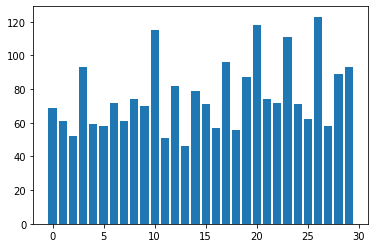

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

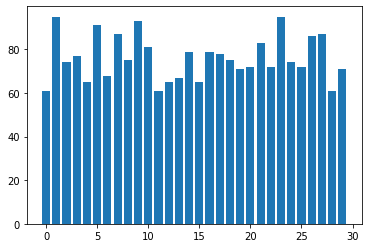

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=False
BALANCED=False
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes,print_f1=True,print_precision=False,print_recall=False, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        self.print_f1=print_f1
        self.print_precision=print_precision
        self.print_recall=print_recall
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            if self.print_precision:
                output['precision_{}'.format(i)]=results[0][i]
            if self.print_recall:
                output['recall_{}'.format(i)]=results[1][i]
            if self.print_f1:
                output['F1_{}'.format(i)]=results[2][i]

In [14]:
class MySequential(keras.Sequential):
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [15]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [16]:
from tensorflow.keras.layers import Conv2D

In [17]:
ConvLayer=Conv2D

In [18]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu1'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu2'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu3'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding='same',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu4'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 12, 1502, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 1500, 64)      640       
_________________________________________________________________
relu1 (LeakyReLU)            (None, 10, 1500, 64)      0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 10, 1500, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 750, 64)     

In [19]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [20]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
71/71 [==============================] - 11s 157ms/step - loss: 3.1617 - accuracy: 0.1523 - F1_0: 0.0758 - F1_1: 0.0000e+00 - F1_2: 0.0922 - F1_3: 0.1405 - F1_4: 0.0499 - F1_5: 0.1211 - F1_6: 0.0399 - F1_7: 0.0652 - F1_8: 0.0390 - F1_9: 0.0000e+00 - F1_10: 0.1886 - F1_11: 0.0000e+00 - F1_12: 0.0244 - F1_13: 0.0180 - F1_14: 0.0467 - F1_15: 0.0598 - F1_16: 0.0236 - F1_17: 0.0890 - F1_18: 0.1337 - F1_19: 0.2435 - F1_20: 0.1180 - F1_21: 0.0000e+00 - F1_22: 0.0471 - F1_23: 0.0617 - F1_24: 0.0339 - F1_25: 0.0652 - F1_26: 0.2988 - F1_27: 0.0232 - F1_28: 0.0663 - F1_29: 0.0297 - val_loss: 4.5976 - val_accuracy: 0.0326 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e

71/71 [==============================] - 10s 146ms/step - loss: 1.0577 - accuracy: 0.7654 - F1_0: 0.6943 - F1_1: 0.5776 - F1_2: 0.8991 - F1_3: 0.8010 - F1_4: 0.8094 - F1_5: 0.7215 - F1_6: 0.6997 - F1_7: 0.5919 - F1_8: 0.7577 - F1_9: 0.6746 - F1_10: 0.8061 - F1_11: 0.5475 - F1_12: 0.7937 - F1_13: 0.5879 - F1_14: 0.7454 - F1_15: 0.8050 - F1_16: 0.8517 - F1_17: 0.7857 - F1_18: 0.5976 - F1_19: 0.7031 - F1_20: 0.7955 - F1_21: 0.8824 - F1_22: 0.7926 - F1_23: 0.5927 - F1_24: 0.6952 - F1_25: 0.7374 - F1_26: 0.8548 - F1_27: 0.7422 - F1_28: 0.6412 - F1_29: 0.7134 - val_loss: 3.0678 - val_accuracy: 0.3062 - val_F1_0: 0.0400 - val_F1_1: 0.0294 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0952 - val_F1_4: 0.6761 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.5316 - val_F1_8: 0.1463 - val_F1_9: 0.0000e+00 - val_F1_10: 0.2564 - val_F1_11: 0.3636 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1143 - val_F1_14: 0.5823 - val_F1_15: 0.2500 - val_F1_16: 0.3529 - val_F1_17: 0.0000e+00 - val_F1_18: 0.0000e+00 

Epoch 14/100
71/71 [==============================] - 10s 146ms/step - loss: 0.3815 - accuracy: 0.9283 - F1_0: 0.9323 - F1_1: 0.8402 - F1_2: 0.9633 - F1_3: 0.9159 - F1_4: 0.9502 - F1_5: 0.8930 - F1_6: 0.9027 - F1_7: 0.9420 - F1_8: 0.9452 - F1_9: 0.9573 - F1_10: 0.9620 - F1_11: 0.8416 - F1_12: 0.8908 - F1_13: 0.9258 - F1_14: 0.8559 - F1_15: 0.9515 - F1_16: 0.8702 - F1_17: 0.9392 - F1_18: 0.8373 - F1_19: 0.8989 - F1_20: 0.9491 - F1_21: 0.9255 - F1_22: 0.8991 - F1_23: 0.9411 - F1_24: 0.8908 - F1_25: 0.9524 - F1_26: 0.9584 - F1_27: 0.8354 - F1_28: 0.9963 - F1_29: 0.9613 - val_loss: 3.0560 - val_accuracy: 0.3376 - val_F1_0: 0.1200 - val_F1_1: 0.1333 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1860 - val_F1_4: 0.7692 - val_F1_5: 0.0000e+00 - val_F1_6: 0.1935 - val_F1_7: 0.4912 - val_F1_8: 0.1690 - val_F1_9: 0.0000e+00 - val_F1_10: 0.1290 - val_F1_11: 0.0784 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0870 - val_F1_14: 0.6667 - val_F1_15: 0.6486 - val_F1_16: 0.2963 - val_F1_17: 0.1786 - val_F1_18: 0.0435

Epoch 21/100
71/71 [==============================] - 10s 147ms/step - loss: 0.2076 - accuracy: 0.9639 - F1_0: 0.8872 - F1_1: 0.9230 - F1_2: 0.9341 - F1_3: 0.9921 - F1_4: 0.9241 - F1_5: 0.9605 - F1_6: 0.9805 - F1_7: 0.9509 - F1_8: 0.9687 - F1_9: 0.9717 - F1_10: 0.9765 - F1_11: 0.9432 - F1_12: 0.9639 - F1_13: 0.9685 - F1_14: 0.9801 - F1_15: 0.9749 - F1_16: 1.0000 - F1_17: 0.9711 - F1_18: 0.9080 - F1_19: 0.9043 - F1_20: 0.9848 - F1_21: 0.9369 - F1_22: 0.9791 - F1_23: 0.9724 - F1_24: 0.9416 - F1_25: 0.9610 - F1_26: 0.9785 - F1_27: 0.9090 - F1_28: 0.9837 - F1_29: 0.9049 - val_loss: 2.6031 - val_accuracy: 0.3877 - val_F1_0: 0.1667 - val_F1_1: 0.1356 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1395 - val_F1_4: 0.5952 - val_F1_5: 0.5600 - val_F1_6: 0.4828 - val_F1_7: 0.5357 - val_F1_8: 0.2500 - val_F1_9: 0.1081 - val_F1_10: 0.3137 - val_F1_11: 0.2857 - val_F1_12: 0.7586 - val_F1_13: 0.2564 - val_F1_14: 0.8140 - val_F1_15: 0.5909 - val_F1_16: 0.5625 - val_F1_17: 0.0000e+00 - val_F1_18: 0.1429 - val_F

Epoch 28/100
71/71 [==============================] - 10s 146ms/step - loss: 0.1280 - accuracy: 0.9802 - F1_0: 0.8874 - F1_1: 0.9926 - F1_2: 0.8664 - F1_3: 0.9919 - F1_4: 0.9752 - F1_5: 0.9493 - F1_6: 0.9861 - F1_7: 0.9637 - F1_8: 0.9743 - F1_9: 0.9595 - F1_10: 0.9894 - F1_11: 0.9176 - F1_12: 0.9912 - F1_13: 0.8333 - F1_14: 0.9137 - F1_15: 0.9935 - F1_16: 0.9972 - F1_17: 0.9807 - F1_18: 0.9828 - F1_19: 0.9788 - F1_20: 0.9924 - F1_21: 0.9631 - F1_22: 0.9715 - F1_23: 0.9826 - F1_24: 0.9849 - F1_25: 0.9390 - F1_26: 0.9810 - F1_27: 0.9888 - F1_28: 0.9896 - F1_29: 0.9844 - val_loss: 3.1369 - val_accuracy: 0.3888 - val_F1_0: 0.1633 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2500 - val_F1_4: 0.8727 - val_F1_5: 0.8387 - val_F1_6: 0.5581 - val_F1_7: 0.3111 - val_F1_8: 0.1905 - val_F1_9: 0.0571 - val_F1_10: 0.2273 - val_F1_11: 0.2154 - val_F1_12: 0.7586 - val_F1_13: 0.2400 - val_F1_14: 0.7600 - val_F1_15: 0.4000 - val_F1_16: 0.6957 - val_F1_17: 0.0000e+00 - val_F1_18: 0.3385 - v

Epoch 35/100
71/71 [==============================] - 10s 146ms/step - loss: 0.1016 - accuracy: 0.9859 - F1_0: 0.9393 - F1_1: 0.9758 - F1_2: 0.9835 - F1_3: 0.9939 - F1_4: 0.9640 - F1_5: 1.0000 - F1_6: 0.9845 - F1_7: 0.9693 - F1_8: 0.9714 - F1_9: 0.9826 - F1_10: 0.9815 - F1_11: 0.9969 - F1_12: 0.9774 - F1_13: 0.9830 - F1_14: 0.9734 - F1_15: 0.9359 - F1_16: 1.0000 - F1_17: 0.9861 - F1_18: 0.9317 - F1_19: 0.9861 - F1_20: 0.9876 - F1_21: 0.9970 - F1_22: 0.9497 - F1_23: 0.9884 - F1_24: 0.9905 - F1_25: 0.9801 - F1_26: 0.9981 - F1_27: 0.9960 - F1_28: 1.0000 - F1_29: 0.9968 - val_loss: 3.1612 - val_accuracy: 0.4098 - val_F1_0: 0.1429 - val_F1_1: 0.1212 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2500 - val_F1_4: 0.7385 - val_F1_5: 0.7333 - val_F1_6: 0.1176 - val_F1_7: 0.3733 - val_F1_8: 0.2593 - val_F1_9: 0.0541 - val_F1_10: 0.5205 - val_F1_11: 0.3750 - val_F1_12: 0.7273 - val_F1_13: 0.3077 - val_F1_14: 0.8889 - val_F1_15: 0.7500 - val_F1_16: 0.5926 - val_F1_17: 0.0000e+00 - val_F1_18: 0.2759 - val_F

Epoch 42/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0918 - accuracy: 0.9828 - F1_0: 0.9827 - F1_1: 0.9679 - F1_2: 0.9655 - F1_3: 0.9868 - F1_4: 0.9992 - F1_5: 0.9613 - F1_6: 0.9897 - F1_7: 0.9724 - F1_8: 0.9825 - F1_9: 0.9806 - F1_10: 0.9440 - F1_11: 0.9667 - F1_12: 0.9939 - F1_13: 0.9636 - F1_14: 0.9795 - F1_15: 1.0000 - F1_16: 0.9501 - F1_17: 0.9444 - F1_18: 0.9402 - F1_19: 0.9568 - F1_20: 0.9690 - F1_21: 1.0000 - F1_22: 0.9719 - F1_23: 0.9981 - F1_24: 0.9705 - F1_25: 0.9107 - F1_26: 0.9956 - F1_27: 0.9777 - F1_28: 0.9958 - F1_29: 0.9954 - val_loss: 3.4998 - val_accuracy: 0.3178 - val_F1_0: 0.1600 - val_F1_1: 0.1408 - val_F1_2: 0.0000e+00 - val_F1_3: 0.3929 - val_F1_4: 0.9091 - val_F1_5: 0.4000 - val_F1_6: 0.2970 - val_F1_7: 0.4348 - val_F1_8: 0.2000 - val_F1_9: 0.2069 - val_F1_10: 0.0930 - val_F1_11: 0.0000e+00 - val_F1_12: 0.2564 - val_F1_13: 0.1081 - val_F1_14: 0.6667 - val_F1_15: 0.6667 - val_F1_16: 0.3673 - val_F1_17: 0.0588 - val_F1_18: 0.0588 - val_F

Epoch 49/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0539 - accuracy: 0.9925 - F1_0: 0.9515 - F1_1: 1.0000 - F1_2: 0.9861 - F1_3: 0.9869 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 0.9994 - F1_7: 0.9861 - F1_8: 0.9535 - F1_9: 0.9583 - F1_10: 0.9909 - F1_11: 0.9762 - F1_12: 0.9947 - F1_13: 0.9861 - F1_14: 0.9971 - F1_15: 0.9861 - F1_16: 0.9936 - F1_17: 1.0000 - F1_18: 0.9766 - F1_19: 0.9839 - F1_20: 0.9941 - F1_21: 0.9583 - F1_22: 0.9391 - F1_23: 0.9964 - F1_24: 0.9938 - F1_25: 0.9861 - F1_26: 0.9858 - F1_27: 0.9843 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 3.2329 - val_accuracy: 0.3853 - val_F1_0: 0.2727 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1860 - val_F1_4: 0.7419 - val_F1_5: 0.4167 - val_F1_6: 0.3333 - val_F1_7: 0.2927 - val_F1_8: 0.1609 - val_F1_9: 0.2128 - val_F1_10: 0.4444 - val_F1_11: 0.2353 - val_F1_12: 0.6316 - val_F1_13: 0.0976 - val_F1_14: 0.7723 - val_F1_15: 0.6429 - val_F1_16: 0.5128 - val_F1_17: 0.0250 - val_F1_18: 0.3030 - val_F

Epoch 56/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0348 - accuracy: 0.9943 - F1_0: 0.9888 - F1_1: 0.9228 - F1_2: 0.9028 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 0.9722 - F1_6: 0.9722 - F1_7: 1.0000 - F1_8: 0.9790 - F1_9: 0.9952 - F1_10: 0.9728 - F1_11: 0.9640 - F1_12: 0.9783 - F1_13: 1.0000 - F1_14: 1.0000 - F1_15: 0.9583 - F1_16: 1.0000 - F1_17: 0.9722 - F1_18: 0.9969 - F1_19: 0.9583 - F1_20: 0.9966 - F1_21: 0.9861 - F1_22: 0.9745 - F1_23: 0.9973 - F1_24: 0.9861 - F1_25: 0.9961 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 0.9981 - F1_29: 1.0000 - val_loss: 2.9373 - val_accuracy: 0.4156 - val_F1_0: 0.0800 - val_F1_1: 0.1818 - val_F1_2: 0.0556 - val_F1_3: 0.0976 - val_F1_4: 0.7419 - val_F1_5: 0.2857 - val_F1_6: 0.3636 - val_F1_7: 0.3600 - val_F1_8: 0.1687 - val_F1_9: 0.3182 - val_F1_10: 0.4179 - val_F1_11: 0.2857 - val_F1_12: 0.7671 - val_F1_13: 0.2857 - val_F1_14: 0.7347 - val_F1_15: 0.6522 - val_F1_16: 0.4444 - val_F1_17: 0.0893 - val_F1_18: 0.0000e+00 - val_F1_19

Epoch 63/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0556 - accuracy: 0.9872 - F1_0: 0.9506 - F1_1: 0.9989 - F1_2: 1.0000 - F1_3: 0.9971 - F1_4: 0.9583 - F1_5: 0.9712 - F1_6: 0.9988 - F1_7: 0.9049 - F1_8: 0.9986 - F1_9: 0.9621 - F1_10: 0.9882 - F1_11: 0.8962 - F1_12: 1.0000 - F1_13: 0.9851 - F1_14: 0.9502 - F1_15: 0.9861 - F1_16: 0.9741 - F1_17: 0.9965 - F1_18: 0.9563 - F1_19: 0.9917 - F1_20: 0.9981 - F1_21: 0.9541 - F1_22: 0.9187 - F1_23: 0.9804 - F1_24: 1.0000 - F1_25: 0.9676 - F1_26: 0.9611 - F1_27: 1.0000 - F1_28: 0.9982 - F1_29: 0.9849 - val_loss: 4.0760 - val_accuracy: 0.2957 - val_F1_0: 0.1026 - val_F1_1: 0.1176 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2647 - val_F1_4: 0.7857 - val_F1_5: 0.4348 - val_F1_6: 0.3902 - val_F1_7: 0.2609 - val_F1_8: 0.1266 - val_F1_9: 0.0571 - val_F1_10: 0.2941 - val_F1_11: 0.1197 - val_F1_12: 0.6429 - val_F1_13: 0.0526 - val_F1_14: 0.7021 - val_F1_15: 0.6038 - val_F1_16: 0.6087 - val_F1_17: 0.0000e+00 - val_F1_18: 0.0000e+00 - v

Epoch 70/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0340 - accuracy: 0.9952 - F1_0: 0.9498 - F1_1: 0.9661 - F1_2: 1.0000 - F1_3: 0.9781 - F1_4: 0.9940 - F1_5: 0.9861 - F1_6: 0.9825 - F1_7: 1.0000 - F1_8: 0.9934 - F1_9: 1.0000 - F1_10: 0.9587 - F1_11: 1.0000 - F1_12: 1.0000 - F1_13: 0.9722 - F1_14: 1.0000 - F1_15: 1.0000 - F1_16: 0.9791 - F1_17: 0.9861 - F1_18: 1.0000 - F1_19: 1.0000 - F1_20: 0.9887 - F1_21: 1.0000 - F1_22: 0.9986 - F1_23: 0.9861 - F1_24: 0.9722 - F1_25: 0.9722 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 3.3979 - val_accuracy: 0.4016 - val_F1_0: 0.1379 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0606 - val_F1_3: 0.3462 - val_F1_4: 0.6849 - val_F1_5: 0.2857 - val_F1_6: 0.3784 - val_F1_7: 0.3200 - val_F1_8: 0.1707 - val_F1_9: 0.0556 - val_F1_10: 0.4231 - val_F1_11: 0.2121 - val_F1_12: 0.8116 - val_F1_13: 0.1071 - val_F1_14: 0.7579 - val_F1_15: 0.5357 - val_F1_16: 0.6923 - val_F1_17: 0.1414 - val_F1_18: 0.4000 - val_F1_19

Epoch 77/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0145 - accuracy: 0.9987 - F1_0: 0.9861 - F1_1: 0.9877 - F1_2: 1.0000 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 0.9861 - F1_6: 0.9892 - F1_7: 0.9722 - F1_8: 1.0000 - F1_9: 1.0000 - F1_10: 1.0000 - F1_11: 0.9691 - F1_12: 1.0000 - F1_13: 0.9861 - F1_14: 1.0000 - F1_15: 1.0000 - F1_16: 0.9648 - F1_17: 1.0000 - F1_18: 1.0000 - F1_19: 1.0000 - F1_20: 0.9860 - F1_21: 1.0000 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 1.0000 - F1_25: 0.9586 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 0.9861 - F1_29: 0.9861 - val_loss: 3.1649 - val_accuracy: 0.4540 - val_F1_0: 0.3265 - val_F1_1: 0.0625 - val_F1_2: 0.0625 - val_F1_3: 0.2909 - val_F1_4: 0.9057 - val_F1_5: 0.2000 - val_F1_6: 0.5714 - val_F1_7: 0.4906 - val_F1_8: 0.1522 - val_F1_9: 0.1622 - val_F1_10: 0.4776 - val_F1_11: 0.2642 - val_F1_12: 0.8056 - val_F1_13: 0.1714 - val_F1_14: 0.7660 - val_F1_15: 0.6667 - val_F1_16: 0.4167 - val_F1_17: 0.0000e+00 - val_F1_18: 0.1290 - val_F1_19

Epoch 84/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0307 - accuracy: 0.9947 - F1_0: 0.9861 - F1_1: 0.9882 - F1_2: 0.9861 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 0.9861 - F1_7: 0.9816 - F1_8: 0.9578 - F1_9: 0.9835 - F1_10: 0.9781 - F1_11: 0.9672 - F1_12: 0.9865 - F1_13: 0.9722 - F1_14: 0.9971 - F1_15: 1.0000 - F1_16: 0.9675 - F1_17: 1.0000 - F1_18: 0.9167 - F1_19: 1.0000 - F1_20: 0.9995 - F1_21: 0.9906 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 0.9930 - F1_25: 0.9861 - F1_26: 0.9996 - F1_27: 0.8573 - F1_28: 0.9861 - F1_29: 0.9965 - val_loss: 3.2331 - val_accuracy: 0.3900 - val_F1_0: 0.1379 - val_F1_1: 0.1935 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2581 - val_F1_4: 0.8364 - val_F1_5: 0.2000 - val_F1_6: 0.2500 - val_F1_7: 0.3200 - val_F1_8: 0.1707 - val_F1_9: 0.2308 - val_F1_10: 0.4681 - val_F1_11: 0.1739 - val_F1_12: 0.6452 - val_F1_13: 0.1667 - val_F1_14: 0.7160 - val_F1_15: 0.7568 - val_F1_16: 0.3871 - val_F1_17: 0.0000e+00 - val_F1_18: 0.0606 - val_F

Epoch 91/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0135 - accuracy: 0.9974 - F1_0: 0.9722 - F1_1: 0.9755 - F1_2: 0.9444 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 1.0000 - F1_7: 0.9583 - F1_8: 0.9861 - F1_9: 0.9808 - F1_10: 0.9722 - F1_11: 0.9861 - F1_12: 0.9861 - F1_13: 0.9861 - F1_14: 1.0000 - F1_15: 0.9852 - F1_16: 1.0000 - F1_17: 0.9645 - F1_18: 1.0000 - F1_19: 1.0000 - F1_20: 0.9994 - F1_21: 0.9904 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 0.9553 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 0.9930 - F1_29: 1.0000 - val_loss: 3.3649 - val_accuracy: 0.4016 - val_F1_0: 0.1600 - val_F1_1: 0.1798 - val_F1_2: 0.0000e+00 - val_F1_3: 0.3636 - val_F1_4: 0.8276 - val_F1_5: 0.5185 - val_F1_6: 0.2857 - val_F1_7: 0.5714 - val_F1_8: 0.1842 - val_F1_9: 0.3934 - val_F1_10: 0.5294 - val_F1_11: 0.2456 - val_F1_12: 0.6824 - val_F1_13: 0.1429 - val_F1_14: 0.6000 - val_F1_15: 0.5116 - val_F1_16: 0.4000 - val_F1_17: 0.0690 - val_F1_18: 0.0000e+00 - val_F

Epoch 98/100
71/71 [==============================] - 10s 146ms/step - loss: 0.0113 - accuracy: 0.9991 - F1_0: 1.0000 - F1_1: 0.9811 - F1_2: 0.9722 - F1_3: 1.0000 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 0.9861 - F1_7: 1.0000 - F1_8: 0.9444 - F1_9: 1.0000 - F1_10: 1.0000 - F1_11: 1.0000 - F1_12: 1.0000 - F1_13: 1.0000 - F1_14: 1.0000 - F1_15: 1.0000 - F1_16: 0.9944 - F1_17: 1.0000 - F1_18: 1.0000 - F1_19: 0.9722 - F1_20: 1.0000 - F1_21: 1.0000 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 0.9722 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 1.0000 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 3.3065 - val_accuracy: 0.4494 - val_F1_0: 0.3684 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2667 - val_F1_4: 0.5618 - val_F1_5: 0.6667 - val_F1_6: 0.5957 - val_F1_7: 0.3750 - val_F1_8: 0.2000 - val_F1_9: 0.3600 - val_F1_10: 0.5333 - val_F1_11: 0.2963 - val_F1_12: 0.5263 - val_F1_13: 0.1463 - val_F1_14: 0.6582 - val_F1_15: 0.7273 - val_F1_16: 0.3929 - val_F1_17: 0.0267 - val_F1_18: 0.1538 - val_F

In [40]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'unaugmented_2.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [41]:
#model.save_weights('phase_1_weights_100_epochs')

In [42]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [43]:
training_history_file

'training_history/unaugmented_2.json'

In [44]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [45]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [46]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

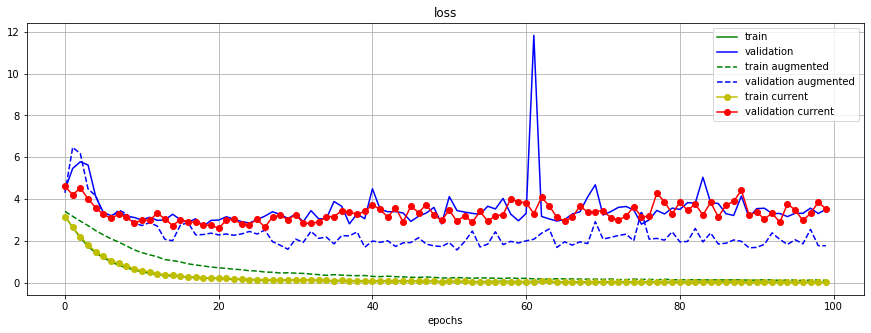

In [47]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

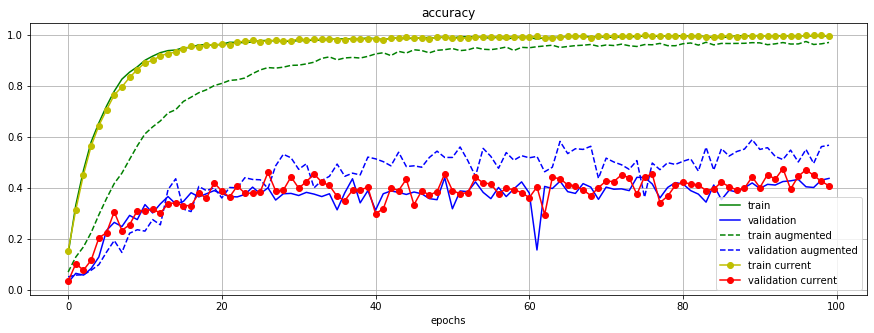

In [48]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

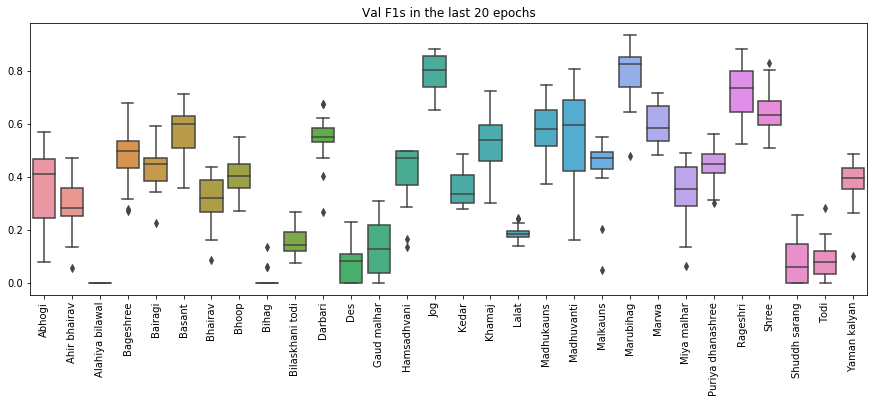

In [49]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

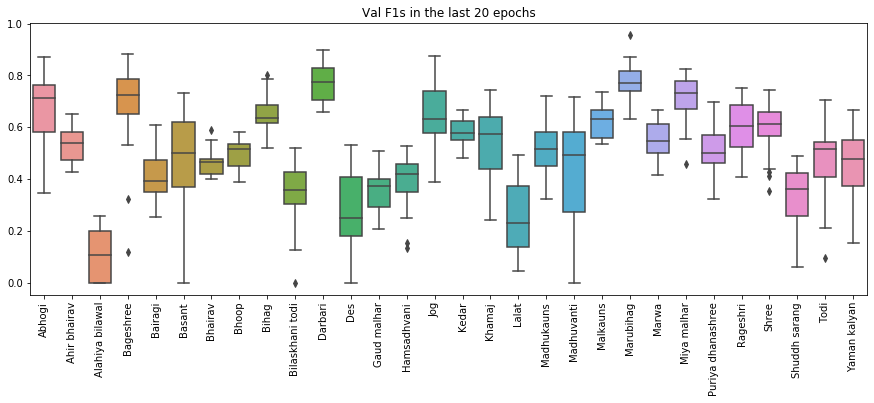

In [50]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

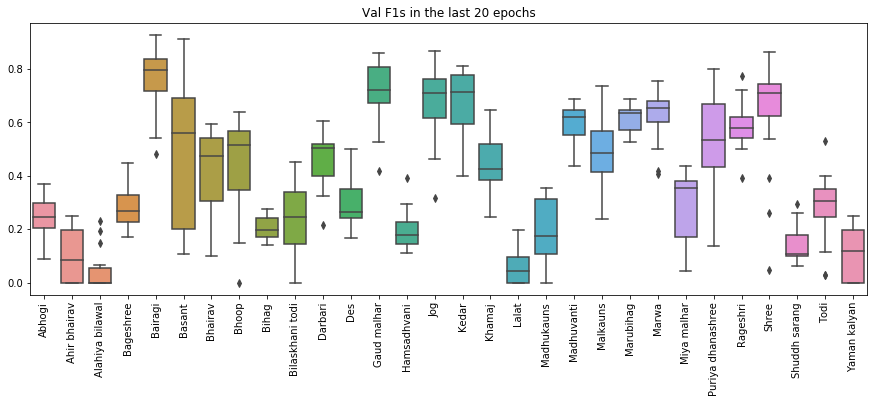

In [51]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

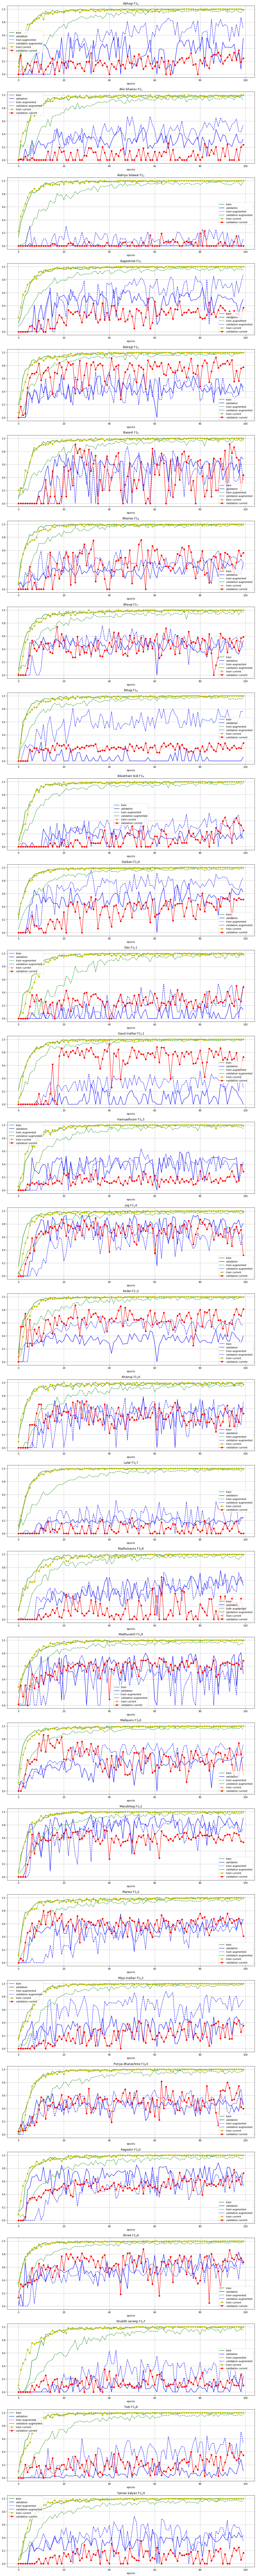

In [52]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [53]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [54]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


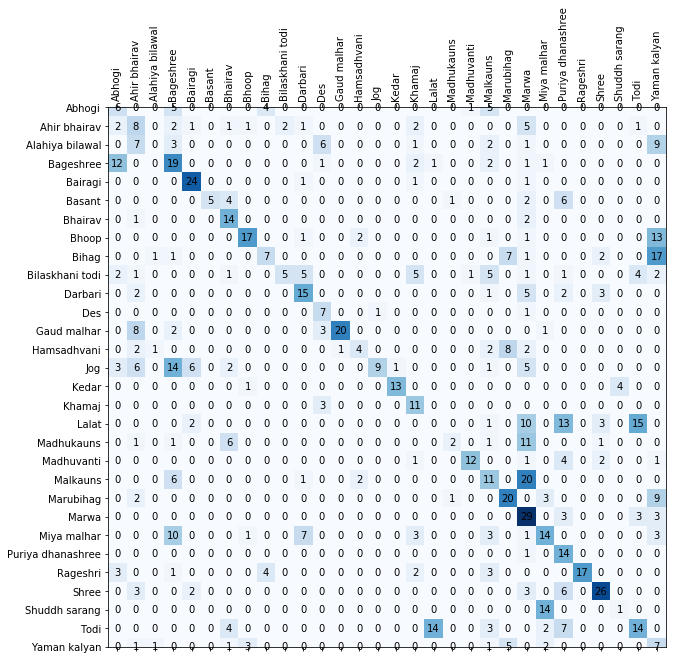

In [55]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [56]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [57]:
precision,recall,f1=process_confusion_matrix(cm)

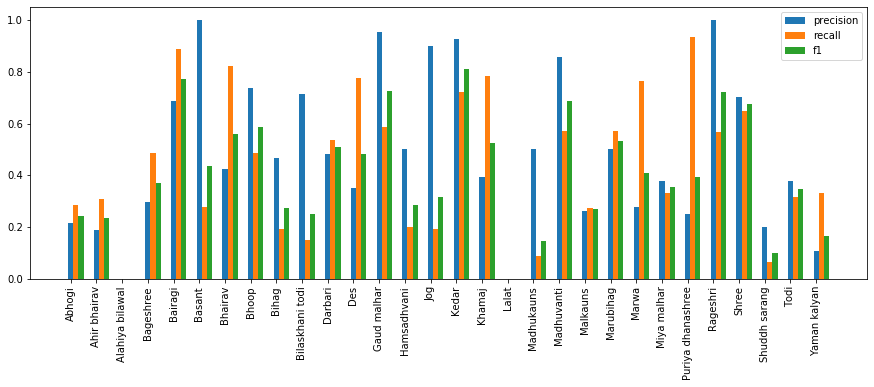

In [58]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>